<a href="https://colab.research.google.com/github/CARRIEE-WU/AIProject/blob/master/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dogs and Cats Classification**

## Connect to GitHub

In [1]:
!git clone https://github.com/a945120/AIProject.git

Cloning into 'AIProject'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 14), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (54/54), 4.22 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (14/14), done.


## Install Kaggle and Download Datasets

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carrieeee86","key":"08f7609e0dc4457990bffdb38191cf82"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                          Online Food Dataset                                  3KB  2024-03-02 18:50:30          13228        263  0.9411765        
syedanwarafridi/vehicle-sales-data                           Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          21467        363  1.0              
kanchana1990/world-air-quality-data-2024-updated             World Air Quality Data 2024 (Updated)                2MB  2024-03-25 15:10:07           1079         28  0.9411765        
bhavikjikadara/student-study-performance                     Student Study Perfo

In [8]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 99% 781M/788M [00:08<00:00, 128MB/s]
100% 788M/788M [00:08<00:00, 98.0MB/s]


In [9]:
!unzip microsoft-catsvsdogs-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/55

## Import Modules

In [10]:
import os
import random
import cv2 as cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

from shutil import copyfile
from tensorflow.keras.layers import Conv2D, Add,MaxPooling2D, Dense, BatchNormalization, Input, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing

In [11]:
CAT_DIR = 'PetImages/Cat'
DOG_DIR = 'PetImages/Dog'

try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/validation')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/validation/cats')
  os.mkdir('/tmp/cats-v-dogs/validation/dogs')
except OSError:
  print('Error failed to make directory')

In [12]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir(DOG_DIR))
n_cats = len(os.listdir(CAT_DIR))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [13]:
def split_data(main_dir, training_dir, validation_dir, split_size):
  """
  Splits the data into train and test sets

  Args:
  main_dir (string):  path containing the images
  training_dir (string):  path to be used for training
  validation_dir (string):  path to be used for validation
  split_size (float): size of the dataset to be used for training
  """
  files = []
  for file in os.listdir(main_dir):
      if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
          files.append(file) # appends file name to a list

  shuffled_files = random.sample(files,  len(files)) # shuffles the data
  split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding

  train = shuffled_files[:split] #training split
  validation = shuffled_files[split:] # validation split

  for element in train:
      copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element)) # copy files into training directory

  for element in validation:
      copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element))# copy files into validation directory

In [ ]:
split_data(CAT_DIR, '/tmp/cats-v-dogs/training/cats', '/tmp/cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, '/tmp/cats-v-dogs/training/dogs', '/tmp/cats-v-dogs/validation/dogs', 0.9)

In [15]:
train_datagen = ImageDataGenerator(
           rescale = 1./255,
           rotation_range = 40,
           width_shift_range = 0.2,
           height_shift_range = 0.2,
           shear_range = 0.2,
           zoom_range = 0.2,
           horizontal_flip = True
           )


valid_datagen = ImageDataGenerator(rescale = 1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
            '/tmp/cats-v-dogs/training',
            batch_size = 32,
            class_mode = 'binary',
            target_size = (224, 224)
            )

validation_generator = valid_datagen.flow_from_directory(
              '/tmp/cats-v-dogs/validation',
              batch_size = 32,
              class_mode = 'binary',
              target_size = (224, 224)
              )

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Data Visualization

In [ ]:
def plot_data(generator, n_images):
  """
  Plots random data from dataset
  Args:
  generator: a generator instance
  n_images : number of images to plot
  """
  i = 1
  images, labels = generator.next()
  labels = labels.astype('int32')

  plt.figure(figsize=(14, 15))

  for image, label in zip(images, labels):
      plt.subplot(4, 3, i)
      plt.imshow(image)
      plt.title(class_names[label])
      plt.axis('off')
      i += 1
      if i == n_images:
        break

  plt.show()

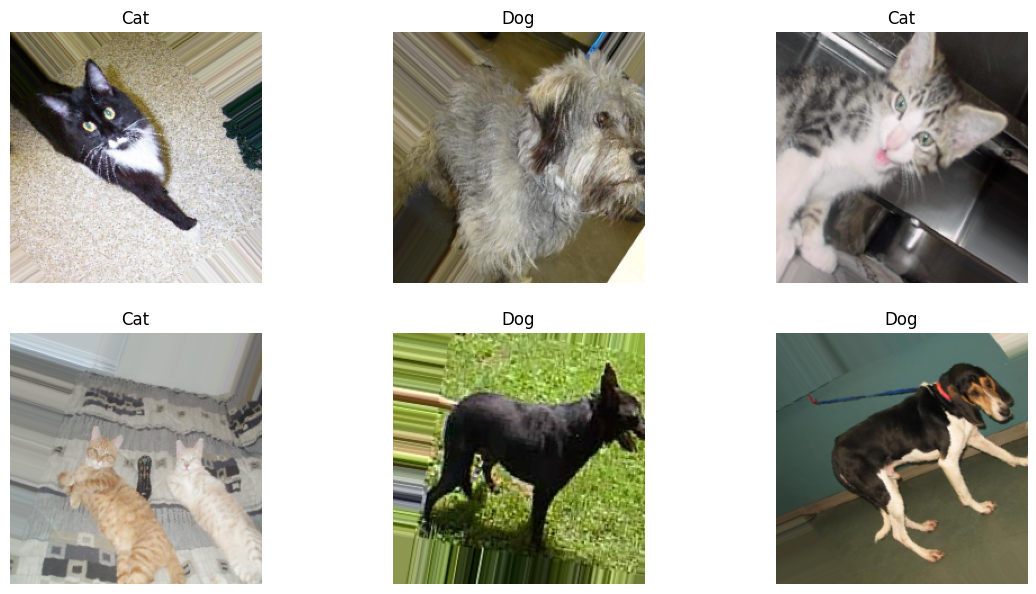

In [17]:
plot_data(train_generator,7)

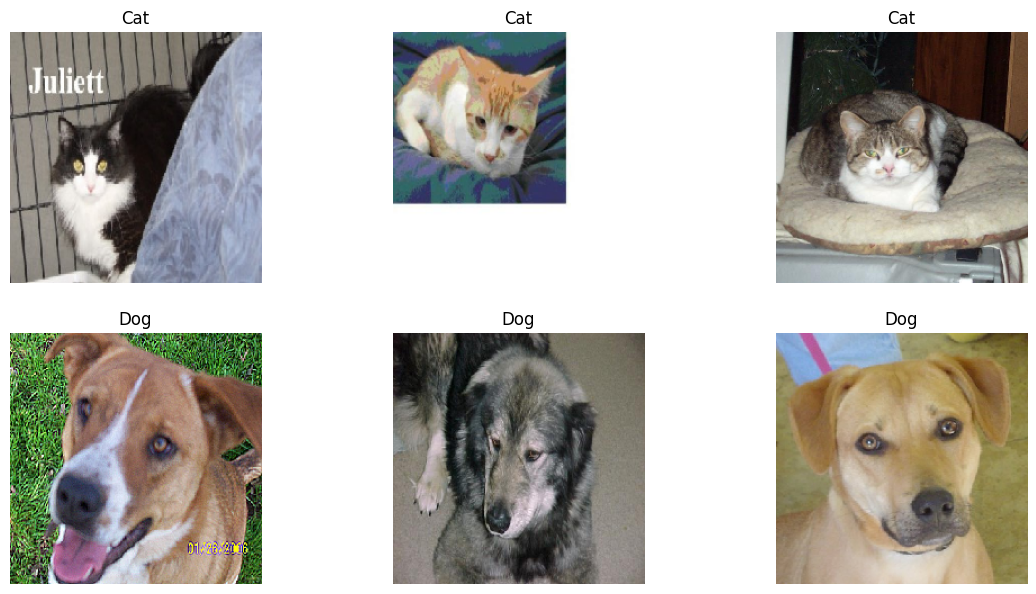

In [18]:
plot_data(validation_generator,7)

## Transfer Learning

In [19]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in inception.layers[:-10]:
  layer.trainable = False # Freeze weights of all layers till except the last 10

last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

87910968/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 12, 12, 768)


In [20]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inception.input, predictions)

# model.summary()

In [21]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [22]:
# Set the training parameters
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )

Model Creation

In [ ]:
history = model.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = 50,
        callbacks=[callback]
        )

Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.9373

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning:

Truncated File Read



704/704 [==============================] - 339s 468ms/step - loss: 0.5476 - accuracy: 0.9373 - val_loss: 0.3656 - val_accuracy: 0.9748 - lr: 1.0000e-04
Epoch 2/50
704/704 [==============================] - 322s 457ms/step - loss: 0.4029 - accuracy: 0.9537 - val_loss: 0.1536 - val_accuracy: 0.9816 - lr: 1.0000e-04
Epoch 3/50
704/704 [==============================] - 316s 449ms/step - loss: 0.3019 - accuracy: 0.9623 - val_loss: 0.1517 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 4/50
704/704 [==============================] - 326s 464ms/step - loss: 0.2282 - accuracy: 0.9653 - val_loss: 0.2534 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 5/50
704/704 [==============================] - 330s 468ms/step - loss: 0.2010 - accuracy: 0.9693 - val_loss: 0.1727 - val_accuracy: 0.9820 - lr: 1.0000e-04
Epoch 6/50
704/704 [==============================] - 322s 457ms/step - loss: 0.1272 - accuracy: 0.9713 - val_loss: 0.1488 - val_accuracy: 0.9864 - lr: 1.0000e-04
Epoch 7/50
704/704 [=============

In [ ]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g')
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r')
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

In [ ]:
plot_prediction(validation_generator, 10)

Visualization of Results

In [ ]:
images, labels =  validation_generator.next()

In [ ]:
def calculate_gradients(images, labels, index):
    """
    Computes gradient of the loss with respect to the input image

    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    index: index of the image
    """
    # get image of the given index and add 1 to it's first dimension
    image = np.expand_dims(images[index],axis=0)
    #convert image to tensor
    image_tensor = tf.convert_to_tensor(image)
    # get the class of the given label and convert it to an integer
    class_index = int(labels[index])
    # one hot encode the labels
    true_value = tf.one_hot([class_index] * image.shape[0], 2)

    # compute the gradient of the loss
    with tf.GradientTape() as tape:
        # Watch the input image
        tape.watch(image_tensor)
        # Generate predictions
        pred  = model(image_tensor)
        # Compute loss
        loss = tf.keras.losses.categorical_crossentropy(true_value, pred)
    # Get the gradient with respect to the image
    gradients = tape.gradient(loss, image_tensor)

    grey_scale_gradients = tf.reduce_sum(tf.abs(gradients),axis=-1)
    normalized_gradients = (255*(grey_scale_gradients - tf.reduce_min(grey_scale_gradients))/
                           (tf.reduce_max(grey_scale_gradients) - tf.reduce_min(grey_scale_gradients)))

    normalized_gradients = tf.squeeze(normalized_gradients)
    normalized_gradients = tf.cast(normalized_gradients, tf.uint8)
    return normalized_gradients,pred

In [ ]:
def show_saliency(images, labels, n_images):
    """
    plot saliency maps
    Args:
    Images: numpy array containing images of shape (n,150,150,3)
    labels: numpy array containing labels shape(n,)
    n_images: number of images to plot
    """
    # Loop for number of images specified
    for i in range(n_images):
        # Computes gradient of the loss with respect to the input image
        gradients,prediction = calculate_gradients(images, labels, i)
        prediction = np.argmax(prediction)
        # Colorize greyscale gradients
        gradient_color = cv2.applyColorMap(gradients.numpy(), cv2.COLORMAP_HOT)
        #Normalize the colored gradients
        gradient_color = gradient_color / 255.0
        # Super impose colored gradients on the image
        super_imposed = cv2.addWeighted(images[i], 0.6, gradient_color, 0.5, 0.1, dtype = cv2.CV_64F)
        print('Predicted Class: ' +str(class_names[prediction]+",\t"+ f'True Class: {class_names[int(labels[i])]}'))
        plt.figure(figsize=(8, 8))
        plt.imshow(super_imposed)
        plt.axis('off')
        plt.show()

In [ ]:
show_saliency(images, labels, 5)

In [ ]:
results = pd.DataFrame(history.history)
results.tail()

In [ ]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()

In [ ]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="plotly_dark",color_discrete_sequence=['#F67280','#DD2706'])
fig.update_layout(
    title_font_color="#41BEE9",
    xaxis=dict(color="#41BEE9",title='Epochs'),
    yaxis=dict(color="#41BEE9")
 )
fig.show()